<div class="alert alert-block alert-info">
⚠️All notebooks should start with the following cell ⚠️.
<br>
<br>
This will ensure that the notebook is set in the correct working directory and that all internal modules can be loaded without setting an entry point.
</div>

In [1]:
from utils import setup_env_path

setup_env_path()

%load_ext autoreload
%autoreload 2

Former working directory:  /workspaces/fil-rouge-pollinisateurs/notebooks
Current working directory:  /workspaces/fil-rouge-pollinisateurs


Setup notebook

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px

In [3]:
path = "data/temporary_data/spipoll.csv"

In [4]:
data = pd.read_csv(path)

/tmp/ipykernel_1063/822284616.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(path)


In [5]:
restricted_vars = [
    "collection_id",
    "plante_sc",
    "plante_fr",
    "insecte_sc",
    "insecte_fr",
    "temperature",
    "vent",
    "latitude",
    "longitude",
    "nebulosite",
    "collection_heure_debut",
]
df = data[restricted_vars].copy()

# Mise en place du modèle



## Compréhension des variables d'intérêt

In [ ]:
var_interet = df["insecte_fr"]

In [ ]:
df.head()

In [ ]:
plt.figure(figsize=(10, 10))
x_values = var_interet.dropna().value_counts().index
y_values = var_interet.dropna().value_counts().values[::-1]
sns.lineplot(x=x_values, y=y_values)

# Fill the area under the curve
plt.fill_between(x_values, y_values, color="skyblue", alpha=0.4)

# Put an xtick each 1000 unique values
plt.xticks(range(0, len(var_interet.value_counts()), 50))
# Instead of the label of the xtick, put the position of the xtick
plt.gca().set_xticklabels(range(0, len(var_interet.value_counts()), 50))

# Put a line on the quartiles
plt.axhline(y=var_interet.value_counts().quantile(0.25), color="red", linestyle="--")
plt.axhline(y=var_interet.value_counts().quantile(0.50), color="red", linestyle=":")
plt.axhline(y=var_interet.value_counts().quantile(0.75), color="red", linestyle="--")

plt.ylim(0, 30000)
plt.xlim(0, len(var_interet.value_counts()))
plt.yscale("symlog")
plt.ylabel("log(count)")
plt.xlabel("Count rank Insecte")
plt.tight_layout()
plt.show()

In [ ]:
counts = df["insecte_sc"].dropna().value_counts().sort_index()

1/4 des données est très peu représenté sur l'attribut `insecte_sc` `insecte_fr` 

In [ ]:
print("insecte_sc")
display(df["insecte_sc"].value_counts().describe())
print("insecte_fr")
display(df["insecte_fr"].value_counts().describe())
print(
    f"Proportion NA insecte_SC: {df['insecte_sc'].isna().sum() / len(df['insecte_sc']) * 100:.2f}%"
)
print(
    f"Proportion NA insecte_FR: {df['insecte_fr'].isna().sum() / len(df['insecte_fr']) * 100:.2f}%"
)

In [ ]:
print(df["insecte_sc"].value_counts().head(100).to_dict())

Visualisation de l'importance de la temporalité

In [ ]:
# get samples where collection_heure_debut is between 18 and 08
# knowing data is in this shape  2019-06-12 12:20:00


df["collection_heure_debut"] = pd.to_datetime(df["collection_heure_debut"])

# plot the distribution of the collection_heure_debut avec les minutes et les heures en x
# Aggreger collection_id

sns.distplot(
    df["collection_heure_debut"].dt.hour + df["collection_heure_debut"].dt.minute / 60
)

In [ ]:
mask = (df["collection_heure_debut"].dt.hour >= 18) | (
    df["collection_heure_debut"].dt.hour <= 7
)
tmp_df = df[mask].copy()

In [ ]:
tmp_df.shape

In [ ]:
# get the intersection of list nunique values of insecte_fr of df and tmp_df

unique_insecte_fr = df["insecte_fr"].dropna().unique()
unique_insecte_fr_tmp = tmp_df["insecte_fr"].dropna().unique()

# get the intersection of list nunique values of insecte_fr of df and tmp_df
intersection = set(unique_insecte_fr).intersection(set(unique_insecte_fr_tmp))

Pour la suite, le jeu de donnée est trop grand pour être traité en local. Il faut donc sous échantilloner.

In [ ]:
df = df.dropna(subset=["insecte_fr"])

In [ ]:
df = df.sample(frac=0.01, random_state=1)

La variable cible n'existe pas dans le jeu de données. Il faut la créer à partir de `insecte_sc` ou `insecte_fr` (ou autre dans le futur).

Pour ça on va regarder autour de chaque observation (wrt. latitude et longitude) si il y a des observations similaires (même `insecte_sc` ou `insecte_fr`). La classe cible sera la quantité d'`insecte_sc` ou `insecte_fr` différents autour de l'observation considérée.


In [ ]:
df.shape

In [ ]:
distance = 0.5

Première intuition

In [ ]:
def calculate_unique_insects(row):
    lat = row["latitude"]
    lon = row["longitude"]
    return df[
        (np.abs(df["latitude"] - lat) <= distance)
        & (np.abs(df["longitude"] - lon) <= distance)
    ]["insecte_fr"].nunique()


# add tqdm to see the progress of the loop in the pandas apply
from tqdm import tqdm

tqdm.pandas()

df["target"] = df.progress_apply(calculate_unique_insects, axis=1)

Deuxième intuition: il faut gagner en vitesse de calcul

In [ ]:
from scipy.spatial import KDTree
from tqdm import tqdm

# Create a KDTree from the latitude and longitude
tree = KDTree(df[["latitude", "longitude"]].values)


# Define a function to calculate the unique insects within the distance
def calculate_unique_insects(row):
    indices = tree.query_ball_point([row["latitude"], row["longitude"]], distance)
    return df.iloc[indices]["insecte_fr"].nunique()


# Apply the function to each row
# use tqdm to display a progress bar
tqdm.pandas()

df["Richesse spécifique"] = df.progress_apply(calculate_unique_insects, axis=1)

Carte de France avec uniquement la richesse spécifique autour de chaque observation. 

In [ ]:
import plotly.express as px

fig = px.scatter_geo(df, lat="latitude", lon="longitude", color="Richesse spécifique")
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

On peut supposer que cette carte ne traduit en réalité que la densité de population humaine: s'il y a beaucoup d'espèces différentes proche des observations c'est peut-être juste qu'il y a beaucoup d'observations. On va comparer avec une carte de la densité d'échantillonnage.

In [ ]:
def calculate_density(row):
    lat = row["latitude"]
    lon = row["longitude"]
    return df[
        (np.abs(df["latitude"] - lat) <= distance)
        & (np.abs(df["longitude"] - lon) <= distance)
    ].shape[0]


df["Densité"] = df.progress_apply(calculate_density, axis=1)

In [ ]:
fig = px.scatter_geo(df, lat="latitude", lon="longitude", color="Densité")
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

In [ ]:
df["Richesse spécifique pondérée"] = df["Richesse spécifique"] / df["Densité"]

En pondérant la target par la densité d'échantillonnage, on devrait avoir une carte plus signficiative de la richesse spécifique. En revanche, la pondération est peut-être trop en défaveur des zones denses: Il y a un nombre d'espèces maximum qui peut se faire effacer par la densité d'échantillonnage.

In [ ]:
fig = px.scatter_geo(
    df, lat="latitude", lon="longitude", color="Richesse spécifique pondérée"
)
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

On va comparer en pondérant plutôt par la densité de collection

In [ ]:
# calcule la densité de collection_id, sachant qu'il peut y avoir un même
# collection_id pour plusieurs lignes
def compute_collection_id_density(row):
    lat = row["latitude"]
    lon = row["longitude"]
    return df[
        (np.abs(df["latitude"] - lat) <= distance)
        & (np.abs(df["longitude"] - lon) <= distance)
    ]["collection_id"].nunique()


# calcule unique insects weighted en divisant target par la quantité d'id collection
df["collection_id density"] = df.progress_apply(compute_collection_id_density, axis=1)

df["Richesse spécifique pondérée par collection"] = (
    df["Richesse spécifique"] / df["collection_id density"]
)

In [ ]:
# plot unique insects weighted coll, and add in the interactive labels the target and the collection_id density
fig = px.scatter_geo(
    df,
    lat="latitude",
    lon="longitude",
    color="Richesse spécifique pondérée par collection",
    hover_data=["target", "collection_id density"],
)
fig.update_geos(fitbounds="locations", visible=True)
fig.show()

## Pipeline de modélisation

In [64]:
df = data[restricted_vars].copy().sample(frac=0.1, random_state=1)
df.shape

(67571, 11)

In [65]:
from models.supervised.preprocessors import MetricsCalculatorNaive as MetricsCalculator

# Add the target variable to the dataframe

distance = 0.5
calculator = MetricsCalculator(distance=distance, clear_intermediate_steps=True)
calculator.fit(df)
df_transformed = calculator.transform(df)

Calculating metrics...


  0%|          | 0/67571 [00:00<?, ?it/s]

100%|██████████| 67571/67571 [03:55<00:00, 287.11it/s]


In [66]:
from models.supervised.preprocessors import HourToCos, DateToJulian

# Add hour to cos tranformation and date to julian day transformation
df_transformed = HourToCos(hour_col="collection_heure_debut").fit_transform(
    df_transformed
)
df_transformed = DateToJulian(date_col="collection_heure_debut").fit_transform(
    df_transformed
)

In [67]:
# check that all transformations have been applied
df_transformed.head(2)

,collection_id,plante_sc,plante_fr,insecte_sc,insecte_fr,temperature,vent,latitude,longitude,nebulosite,collection_heure_debut,weighted_specific_richness,collection_heure_debut_cos,collection_heure_debut_julian
172218,19 068,Les Angéliques (Angelica sp),NaN,NaN,Les Mouches difficiles à déterminer,20-30ºC,"faible, irrégulier",48.841331,2.358497,0-25%,2016-05-02 11:30:00.000,0.058677,-0.991445,2.457511e+06
37176,4 091,Daucus carota,Carotte sauvage,Hylaeus,Les Abeilles Hylaeus à taches blanches,20-30ºC,"faible, irrégulier",48.213400,-1.693901,0-25%,2019-07-24 09:30:00.000,0.060071,-0.793353,2.458689e+06


In [68]:
df_transformed.columns

Index(['collection_id', 'plante_sc', 'plante_fr', 'insecte_sc', 'insecte_fr',
       'temperature', 'vent', 'latitude', 'longitude', 'nebulosite',
       'collection_heure_debut', 'weighted_specific_richness',
       'collection_heure_debut_cos', 'collection_heure_debut_julian'],
      dtype='object')

In [69]:
numeric_features = [
    "latitude",
    "longitude",
    "collection_heure_debut_cos",
    "collection_heure_debut_julian",
]

ordinal_features = ["vent", "nebulosite", "temperature"]

nominal_features = [
    "plante_fr",
    # ....
]

categorical_features = ordinal_features + nominal_features

used_features = numeric_features + ordinal_features + nominal_features

In [70]:
X = df_transformed[used_features]
y = df_transformed["weighted_specific_richness"]

In [71]:
X.head()

,latitude,longitude,collection_heure_debut_cos,collection_heure_debut_julian,vent,nebulosite,temperature,plante_fr
172218,48.841331,2.358497,-0.991445,2.457511e+06,"faible, irrégulier",0-25%,20-30ºC,NaN
37176,48.213400,-1.693901,-0.793353,2.458689e+06,"faible, irrégulier",0-25%,20-30ºC,Carotte sauvage
618860,44.717569,4.547003,-0.854912,2.459992e+06,"faible, irrégulier",0-25%,10-20ºC,Laurier tin
316812,46.810336,6.382778,-0.999048,2.456499e+06,"faible, irrégulier",0-25%,20-30ºC,NaN
92345,48.135764,-1.697600,-0.790690,2.458332e+06,"faible, irrégulier",0-25%,20-30ºC,NaN


Il FAUT gérer les données manquantes. Pour ça on va utiliser un KNN qui va chercher les observations les plus proches pour compléter les données manquantes !

https://scikit-learn.org/stable/auto_examples/impute/plot_missing_values.html#sphx-glr-auto-examples-impute-plot-missing-values-py

In [24]:
# idée: utiliser un KNN modifié pour remplacer les données par les plus proches spatialement !

In [129]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from models.supervised.preprocessors import HourToCos, DateToJulian

numeric_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("imputer", KNNImputer(n_neighbors=5)),
    ]
)

# make a pipeline for the categorical features (that combines ordinal and nominal)
categorical_pipeline = Pipeline(
    steps=[
        (
            "encoding",
            ColumnTransformer(
                transformers=[
                    ("ordinal", OrdinalEncoder(), ordinal_features),
                    (
                        "nominal",
                        OneHotEncoder(handle_unknown="ignore"),
                        nominal_features,
                    ),
                ],
                remainder="drop",
            ),
        ),
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_pipeline, numeric_features),
        ("categorical", categorical_pipeline, categorical_features),
    ],
    remainder="drop",
)

estimator = RandomForestRegressor(random_state=1)

# estimator = LinearRegression()

pipe = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("passthrough", "passthrough"),
        ("estimator", estimator),
    ]
)
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  ['latitude', 'longitude',
                                                   'collection_heure_debut_cos',
                                                   'collection_heure_debut_julian']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   ColumnTransformer(transformers=[('ordinal',
                                                                                                    OrdinalEncoder(),
                                                                                                    ['vent',
                                                                                                     'nebulosite',
                                                                                                     'temperature']),
                                                                                                   ('nominal',
                                                                                                    OneHotEncoder(handle_unknown='ignore'),
                                                                                                    ['plante_fr'])])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vent', 'nebulosite',
                                                   'temperature',
                                                   'plante_fr'])])),
                ('passthrough', 'passthrough'),
                ('estimator', RandomForestRegressor(random_state=1))])

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [131]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('imputer',
                                                                   KNNImputer())]),
                                                  ['latitude', 'longitude',
                                                   'collection_heure_debut_cos',
                                                   'collection_heure_debut_julian']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoding',
                                                                   ColumnTransformer(transformers=[('ordinal',
                                                                                                    OrdinalEncoder(),
                                                                                                    ['vent',
                                                                                                     'nebulosite',
                                                                                                     'temperature']),
                                                                                                   ('nominal',
                                                                                                    OneHotEncoder(handle_unknown='ignore'),
                                                                                                    ['plante_fr'])])),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['vent', 'nebulosite',
                                                   'temperature',
                                                   'plante_fr'])])),
                ('passthrough', 'passthrough'),
                ('estimator', RandomForestRegressor(random_state=1))])

In [94]:
pipe.predict(X_test)

array([0.28182804, 0.0744868 , 0.22727273, ..., 0.07271852, 0.27791563,
       0.15056818])

In [95]:
# make all the scores for regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = pipe.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"R2 score: {r2_score(y_test, y_pred):.2f}")

Mean squared error: 0.00
Mean absolute error: 0.00
R2 score: 0.99


In [133]:
importance = pipe.named_steps["estimator"].feature_importances_
# use passthrough step to get the features names
features = pipe.named_steps
features

'passthrough'

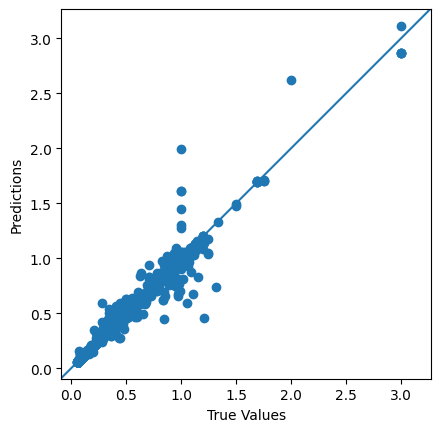

In [122]:
# plot y_test vs y_pred
plt.scatter(y_test, y_pred )
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.axis("square")
_ = plt.plot([-100, 100], [-100, 100])